In [76]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
source_folder = "../data/interim/"

# define tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenizer max sentance lenth
max_input_length = 100

# initialize pretrained model
bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [78]:
class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        embedding_dim = bert.config.to_dict()['hidden_size']
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        #text = [batch size, sent len] 
        
        with torch.no_grad():
            embedded = self.bert(text)[0]       
        #embedded = [batch size, sent len, emb dim]
        _, hidden = self.rnn(embedded)
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])      
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        #output = [batch size, out dim]
        
        return output

In [84]:
# instantiate model

HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.6

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)
model.load_state_dict(torch.load("../models/binary_transformer_model.pt"))
model.eval()

BERTGRUSentiment(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [122]:
test_df = pd.read_csv("../data/interim/test_bin_data.csv")
test_labels = test_df["1"].values

In [170]:
def preprocess_and_predict(sentence):
    '''
    Tokenizes a sentances, removes two characters from maximum length (282) and 
    converts tokens to corresponding embedding index
    
    Returns: embedding indices tensor of tokens in sentence
    '''
    
    inputs = tokenizer(sentence, padding=True, return_tensors="pt")
    indicies_tensor = inputs["input_ids"]
    return indicies_tensor

In [171]:
predictions = []
for sentence in test_df["10"]:
    indices = tokenize_cut_embed(sentence)
    pred = model(indices)
    pred = torch.round(torch.sigmoid(pred))
    predictions.append(float(pred))

In [172]:
test_f1 = f1_score(test_labels, predictions, average="weighted")
print("Test F1:", test_f1)

Test F1: 0.921895343843184


In [173]:
# Estimated. Could have humans label some to get a better estimate. Will be our estimate of Bayes Error
human_f1 = 0.99 
train_f1 = 0.82
validation_f1 = 0.72

<AxesSubplot:>

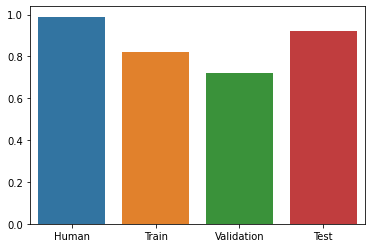

In [174]:
sns.barplot(x=["Human", "Train", "Validation", "Test"], y=[human_f1, train_f1, validation_f1, test_f1])

In [175]:
avoidable_bias = human_f1 - train_f1
variance = train_f1 - validation_f1
overfit_to_validation = validation_f1 - test_f1

In [176]:
print(f"Test F1: {test_f1}")
print(f"Avoidable Bias: {avoidable_bias}")
print(f"Variance: {variance}")
print(f"Validation F1 - Test F1: {overfit_to_validation}")

Test F1: 0.921895343843184
Avoidable Bias: 0.17000000000000004
Variance: 0.09999999999999998
Validation F1 - Test F1: -0.20189534384318397


In [177]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1243
           1       0.80      0.67      0.73       221

    accuracy                           0.92      1464
   macro avg       0.87      0.82      0.84      1464
weighted avg       0.92      0.92      0.92      1464



In [178]:
np.sum(predictions)

183.0